# SudoQ

## Librerías

In [1]:
import numpy as np
from qiskit.visualization import plot_histogram, array_to_latex, plot_state_city, plot_bloch_vector, plot_state_qsphere
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, partial_trace
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_func import *
import itertools
import operator
import math
import time

In [2]:
IBM = IBMRuntime()
service = IBM.qiskit_log()

## Definición del Circuito

In [3]:
nQbits = 14;                        
q      = QuantumRegister(nQbits)   
c      = ClassicalRegister(nQbits) 
qc     = QuantumCircuit(q,c)
Statevector(qc).draw("latex")

<IPython.core.display.Latex object>

In [4]:
qc.h(range(nQbits))
Statevector(qc).draw("latex")

<IPython.core.display.Latex object>

## Funciones

In [5]:
def permutation(classicalB):
    aux      = [0, 1, 2, 3]                             
    list_out = []
    for i in aux:
        if i not in classicalB:                         
            list_out.append(i)
    list_out_2 = list(itertools.permutations(list_out)) 
    return list_out_2

In [6]:
def qbit_to_binary(perm):
    perm_bin = []
    for item in list(perm):
        binary_num = ""
        for i in item:
            prm_b = format(i,"b")
            if len(prm_b)==1:                  
                prm_b = '0' + prm_b
            binary_num = binary_num + prm_b
        perm_bin.append(binary_num)
    return perm_bin

In [7]:
def oracle(qc, l_qbits, l_perm_bin):
    for item in l_perm_bin:
        cont = 0                                            
        for j in item:
            if j == '0':
                qc.x(l_qbits[cont])
            cont+=1
        qc.h(l_qbits[0])
        qc.mcx(l_qbits[1:len(l_qbits)],l_qbits[0])           
        qc.h(l_qbits[0])
        cont = 0
        for j in item:                                      
            if j == '0':
                qc.x(l_qbits[cont])
            cont+=1
    Statevector(qc).draw("latex")
    return qc   

In [8]:
def reflector(qc, l_qbits):
    qc.h(l_qbits)                                       
    qc.x(l_qbits)                                      
    qc.h(l_qbits[0])
    qc.mcx(l_qbits[1:len(l_qbits)],l_qbits[0]) 
    qc.h(l_qbits[0])
    qc.x(l_qbits)                                      
    qc.h(l_qbits)                                      
    return qc  

In [9]:
def grover(qc,l_qbits, l_bits):    
    if len(l_qbits) == 2:           
        n_rep = 1
    elif len(l_qbits) == 4:
        n_rep = 1
    else:
        n_rep = 2  
    perm      = permutation(l_bits)      
    perm_bin  = qbit_to_binary(perm) 
    for i in range(n_rep):          
        oracle(qc,l_qbits,perm_bin)
        reflector(qc,qc.qubits)
    return qc  

## Ejecución del Algoritmo

In [10]:
start_time = time.time()
for _ in range(2):

    # Condiciones filas

    grover(qc,[q[0],q[1]],[0,1,2])
    grover(qc,[q[2],q[3],q[4],q[5]],[2,3])
    grover(qc,[q[6],q[7],q[8],q[9]],[2,3])
    grover(qc,[q[10],q[11],q[12],q[13]],[1,3])

    # Condiciones columnas

    grover(qc,[q[0],q[1],q[6],q[7]],[1,2])
    grover(qc,[q[2],q[3],q[10],q[11]],[0,3])
    grover(qc,[q[4],q[5],q[8],q[9]],[2,3])
    grover(qc,[q[12],q[13]],[1,2,3])

    # Condiciones bloques

    grover(qc,[q[0],q[1],q[2],q[3]],[0,2])
    grover(qc,[q[4],q[5]],[1,2,3])
    grover(qc,[q[6],q[7],q[10],q[11]],[1,3])
    grover(qc,[q[8],q[9],q[12],q[13]],[2,3])

elapsed_time_grover = time.time() - start_time
print(elapsed_time_grover/60)

2.0351131319999696


In [11]:
qc.measure(q,c)
simulator = AerSimulator()
qc = transpile(qc, simulator)
result = simulator.run(qc, shots=2048*128).result()
counts = result.get_counts(qc)
graph_dict=dict(sorted(counts.items(), key=operator.itemgetter(1))[-5:])

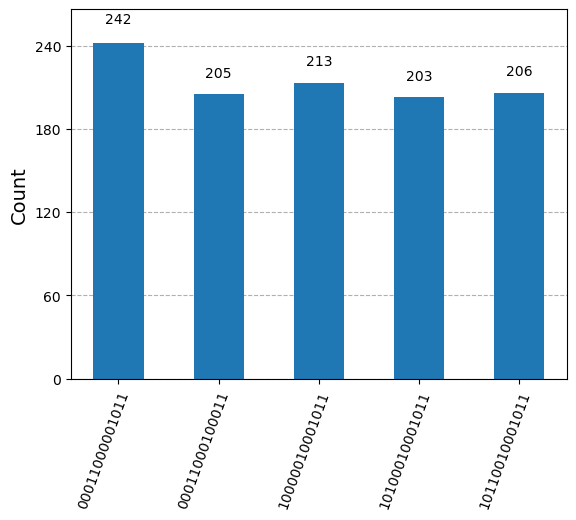

In [12]:
plot_histogram(graph_dict)

backend = service.least_busy(operational=True,simulator=False)
qc = transpile(qc, backend)
print(backend)

sampler = Sampler(backend)
job = sampler.run([qc])
result = job.result()

counts = result[0].data.c0.get_counts()
print(sorted(counts.items(), key=operator.itemgetter(1))[-5:])